# ClothesPicker


In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
from utils import Preprocess, Clothing, AllClothes, ImageCaptioner

In [138]:
from PIL import Image, ImageFilter
import glob
import os
import numpy as np
import random
import json
import re
from tqdm import tqdm

In [4]:
def show(array):
    Image.fromarray(array).show()

In [5]:
preprocessing = [
    ("resize", {"size":255}),
    ("square_crop", {"size":224}),
    # ("background", {})
]
clothes = AllClothes()
clothes.clothes = [Clothing(Image.open(f), preprocessing) for f in glob.glob("./photos/*")]

## Image Captioning

In [47]:
from bardapi import BardCookies
import io

In [48]:
test_image = clothes[0].image

In [40]:
# so as to not expose the api key (based on this guide: https://github.com/dsdanielpark/Bard-API#authentication)
bard_key = input("enter bard key")

enter bard key aQiKlcuJ8XuzNiptVGh6CLzm-UC7CgHSNcGiGNkfS0T8ANPorzPMs2ITT7seK_-hsqwPXA.


In [42]:
from bardapi import BardCookies

cookie_dict = {
    "__Secure-1PSID": "",
    "__Secure-1PSIDTS": ""
}

In [44]:
bard = BardCookies(cookie_dict=cookie_dict)

In [53]:
b = io.BytesIO()
test_image.save(b, format="PNG")

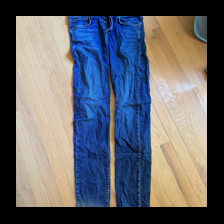

In [76]:
index = random.randint(0, len(clothes.clothes)-1)
display(clothes[index].image)
response = bard.ask_about_image("Describe this article of clothing", image=clothes[index].bytes)

In [80]:
print(choices['content'])

The article of clothing in the image is a pair of blue jeans. They are sitting on a wooden floor. The jeans are made of denim, a sturdy cotton fabric. They have a straight leg and a button fly. There are five pockets on the jeans: two front pockets, two back pockets, and a coin pocket. The jeans are in good condition and appear to be new or recently washed.

Is there anything else I can help you with?


## Lets try some prompts:

In [13]:
prompt = """Describe this article of clothing. You should describe the article of categories in a json format using the example below:
```
{
    color: COLOR,
    category: Pants, Tshirt, Jacket, Polo Shirt, ...,
    description: SHORT DESCRIPTION,
    material: MATERIAL,
    season, WINTER, SUMMER, FALL, SPRING, ALL
    
}
```
"""
pattern = r"\{(.*?)\}"


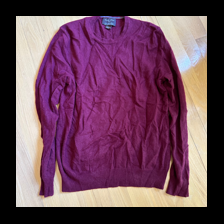

{'color': 'Purple', 'category': 'Sweater', 'description': 'A purple crew-neck sweater made of merino wool.', 'material': 'Merino wool', 'season': 'FALL, WINTER'}


In [117]:
index = random.randint(0, len(clothes.clothes)-1)
display(clothes[index].image)
response = bard.ask_about_image(input_text=prompt, image=clothes[index].bytes)
pattern = r"\{(.*?)\}"
matches = re.findall(pattern, response['content'], re.DOTALL)
print(json.loads(f"{{\n{matches[0]}\n}}"))

In [118]:
a = re.compile(pattern)

### Class ImageCaptioner:

In [4]:
cookie_dict = {
    "__Secure-1PSID": "aQiKlcuJ8XuzNiptVGh6CLzm-UC7CgHSNcGiGNkfS0T8ANPoARgcG8Ra4NHjG56xYki87A.",
    "__Secure-1PSIDTS": "sidts-CjEBSAxbGcH6n51q3Fl6c2BKQQ1vXeslVjUZxRYQSE3tOGyZoSiqM7ClQ98QSajRc_vqEAA"
} # bard cookiedict

captioner = ImageCaptioner(cookie_dict)

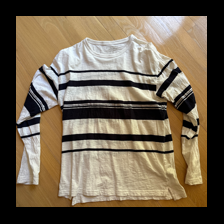

In [16]:
display(clothes[5].image)
data = captioner(clothes[5])

In [17]:
print(data)

{'color': 'Black and white', 'category': 'T-shirt', 'description': 'A black and white striped t-shirt made of cotton.', 'material': 'Cotton', 'season': 'ALL'}


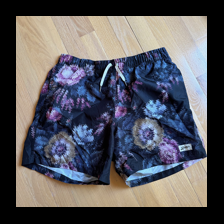

{'color': 'Blue',
 'category': 'Shorts',
 'description': 'A pair of blue shorts made of cotton.',
 'material': 'Cotton',
 'season': 'Summer'}

In [21]:
display(clothes[30].image)
captioner(clothes[30])

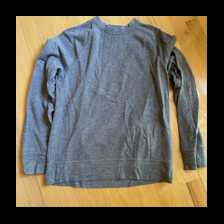

{'color': 'gray',
 'category': 'T-shirt',
 'description': 'A gray crew neck t-shirt made of cotton.',
 'material': 'cotton',
 'season': 'ALL'}

In [24]:
display(clothes[40].image)
captioner(clothes[40])

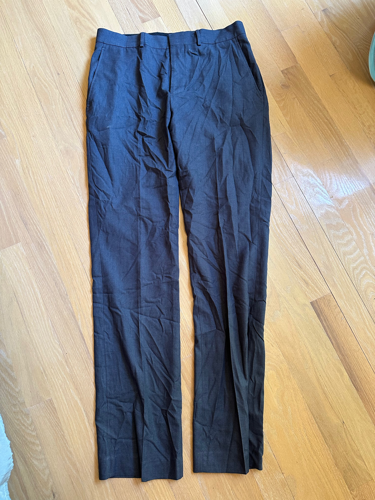

In [36]:
high_res = Clothing(Image.open("./photos/IMG_0238.jpeg"), preprocessing=[])
# these are suit pants:
display(Preprocess.resize(high_res.image, 500))

In [83]:
captioner(clothing=high_res)

{'color': 'Black',
 'category': 'Pants',
 'description': 'A pair of black pants made of cotton.',
 'material': 'Cotton',
 'season': 'ALL'}

## NO NEED TO RUN BELOW:

import os
import psycopg2
from dotenv import load_dotenv

from utils import *
from tqdm.notebook import tqdm
from dotenv import load_dotenv
import time

load_dotenv()

cookie_dict = {
    "__Secure-1PSID": "aQiKlcuJ8XuzNiptVGh6CLzm-UC7CgHSNcGiGNkfS0T8ANPoARgcG8Ra4NHjG56xYki87A.",
    "__Secure-1PSIDTS": "sidts-CjEBSAxbGcH6n51q3Fl6c2BKQQ1vXeslVjUZxRYQSE3tOGyZoSiqM7ClQ98QSajRc_vqEAA"
} # bard cookiedict

captioner = ImageCaptioner(cookie_dict)

preprocessing = [("resize", {"size": 1024})]
clothes_path = glob.glob("./photos/*")
clothes = AllClothes()
clothes.clothes = [Clothing(Image.open(f), preprocessing) for f in clothes_path]

# okay lets just upload all the clothing
import glob


# db = DB()
# fuck using DB
start = time.time()
for cloth, fpath in zip(clothes.clothes, clothes_path):
    # caption:
    item = captioner(clothing=cloth)
    db = psycopg2.connect(os.environ['DBURL'])
    try:
        sql = f"""INSERT INTO clothing (color, category, description, material, season, filepath) VALUES ('{item['color']}', '{item['category']}', '{item['description'].replace("'", "")}', '{item['material']}', '{item['season']}', '{fpath}')"""
    except:
        continue
    with db.cursor() as cursor:
        cursor.execute(sql)
        db.commit()
        
    print(time.time() - start)
    start = time.time()
        
    

In [18]:
with db.cursor() as cur:
    d = cur.execute("SELECT * FROM clothing")
    d = cur.fetchall()

In [19]:
d[0]

(102,
 'Black',
 'Jacket',
 'A black suit jacket with a single-breasted button closure and two flap pockets.',
 'Wool',
 'Fall/Winter',
 './photos/IMG_0240.jpeg')

In [34]:
data = db.commit()

In [35]:
data

In [42]:
d[0]

(102,
 'Black',
 'Jacket',
 'A black suit jacket with a single-breasted button closure and two flap pockets.',
 'Wool',
 'Fall/Winter',
 './photos/IMG_0240.jpeg')

# FRESH START WITH NEW LOADERs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *
from tqdm.notebook import tqdm
from dotenv import load_dotenv
import time
import os
import psycopg2

In [3]:
load_dotenv()

True

In [4]:
all_clothes = AllClothes._from_DB([("resize",{"size":500})])

# Vectorization:

In [1]:
%load_ext autoreload
%autoreload 2
from utils import *
import time

In [2]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

In [3]:
s = time.time()
# CREATE ALL CLOTHES
all_clothes = AllClothes._from_DB(
    [
        ("resize", {"size":500}),
    ]
)

print(f"Time: {time.time()-s:.2f} seconds")

Time: 7.40 seconds


In [4]:
small_clothes = AllClothes(clothes=all_clothes.clothes[:10])

In [5]:
vector_db = VectorDB()

In [6]:
vector_db.embeddings

array([], shape=(0, 384), dtype=float64)

In [7]:
vector_db.insert(small_clothes[0], str)

In [8]:
vector_db.itoo

{0: <utils.Clothing at 0x147f20a90>}

In [9]:
vector_db.knn(small_clothes[0])

[(<utils.Clothing at 0x147f20a90>, 0.9999999652975629)]

### Actually testing VectorDB

In [10]:
vector_db = VectorDB(unit_vectors=True)

In [11]:
s = time.time()
vector_db.batch_insert(small_clothes.clothes)
print(f"Time to insert {len(small_clothes.clothes)} items: {time.time()-s:.2f} seconds")

Time to insert 10 items: 0.03 seconds


A gray crewneck sweater made of soft cotton.


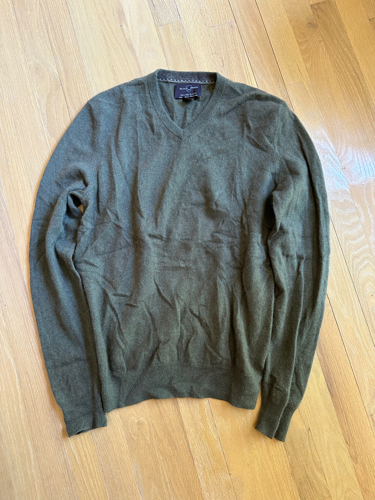

In [12]:
cloth = all_clothes[30]
print(cloth)
display(cloth.image)
k3 = vector_db.knn(cloth, k=3)

In [13]:
k3

[(<utils.Clothing at 0x137dca400>, 0.6652349018118909),
 (<utils.Clothing at 0x137dca0a0>, 0.5858602265029158),
 (<utils.Clothing at 0x147fb1370>, 0.4540844191383496)]

A black sweater made of soft, knitted cotton.


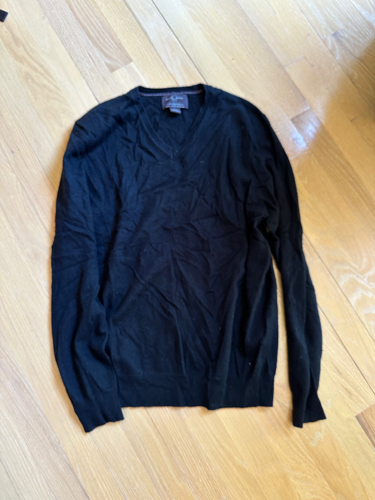

A plain white t-shirt with a crew neck. It is made of 100% cotton and is suitable for all seasons.


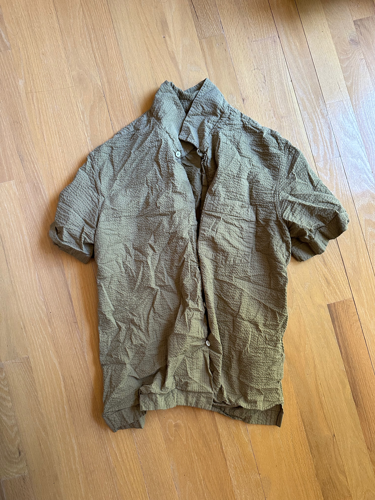

A plain blue t-shirt with a crew neck.


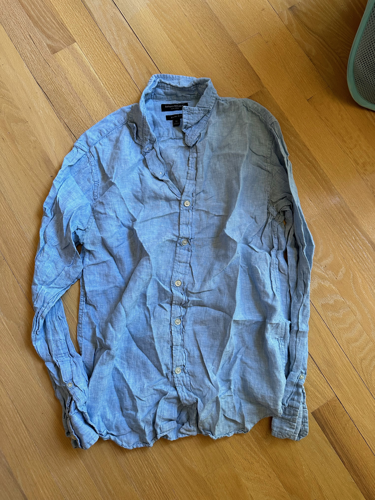

In [14]:
for c, _ in k3:
    print(str(c))
    display(c.image)

## TRYING WITH JSON

In [15]:
def json_true(x):
    x.json=True
all_clothes.apply(func=json_true)
# this modifies small_clothes too because the clothes are the same

In [16]:
for i in range(len(vector_db)):
    vector_db.pop(len(vector_db)-1)

In [25]:
vector_db.batch_insert(small_clothes.clothes)

{"color": "Gray", "category": "Sweater", "material": "Cotton", "description": "A gray crewneck sweater made of soft cotton.", "season": "FALL, WINTER"}


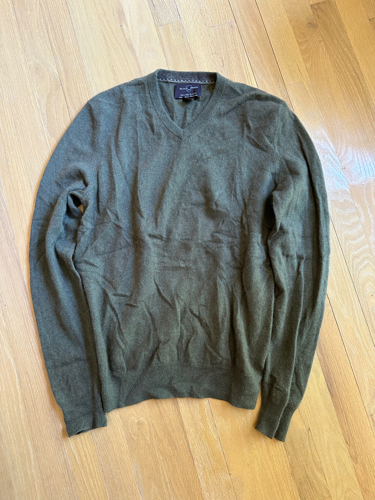

In [26]:
cloth = all_clothes[30]
print(cloth)
display(cloth.image)
k3 = vector_db.knn(cloth, k=3)

{"color": "Black", "category": "Sweater", "material": "Cotton", "description": "A black sweater made of soft, knitted cotton.", "season": "Fall, Winter"}


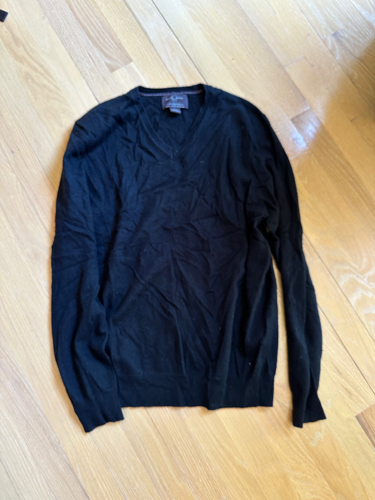

{"color": "White and Black", "category": "T-shirt", "material": "Cotton", "description": "A short-sleeved shirt with a white and black striped pattern.", "season": "ALL"}


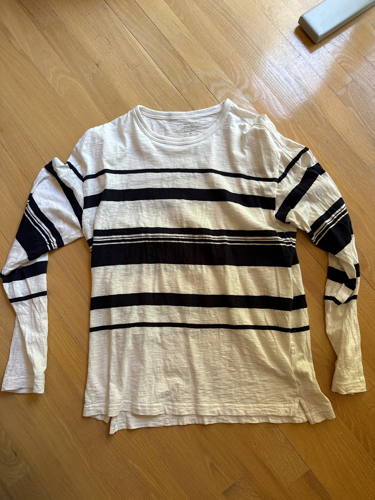

{"color": "White", "category": "T-shirt", "material": "Cotton", "description": "A plain white t-shirt with a crew neck. It is made of 100% cotton and is suitable for all seasons.", "season": "ALL"}


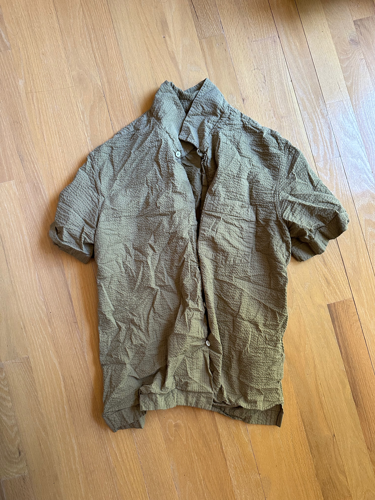

In [27]:
for c, _ in k3:
    print(str(c))
    display(c.image)

# Outfit Editor

In [1]:
%load_ext autoreload
%autoreload 2
from utils import *
import time

In [2]:
cookie_dict = {
    "__Secure-1PSID": "awiKlRJqxV2D_Z3TVeA2D5F_aBkHluyLHPqRvCDdosokZ0twOLIJcsmvnxzgLU2cwtCnnQ.",
    "__Secure-1PSIDTS": "sidts-CjEBSAxbGaDUwbDtfxQ9G41LEcORyeRXAgJ-IKACiqLx2rwK_Da1NcKTn7BG6GrEVZUJEAA"
} # bard cookiedict

In [42]:
picker = OutfitPlanner(cookie_dict, clothes_json=False)

In [64]:
resp = picker.outfit_query("the weather is 32 degrees fahrenheit, I would like to wear something formal.")

In [65]:
resp

[{'category': 'Top',
  'clothing description': 'A white dress shirt with a button-down collar and French cuffs.'},
 {'category': 'Bottoms',
  'clothing description': 'A pair of black dress pants with a straight leg.'},
 {'category': 'Shoes', 'clothing description': 'A pair of black dress shoes.'},
 {'category': 'Outerwear', 'clothing description': 'A black overcoat.'}]

# NOTE:
the captions are sorta jank so things are printed like plain tshirts etc but actually arent ...

Score: 0.48 | CAPTION: A white polo shirt made of cotton pique fabric. It has a button-down collar, short sleeves, and a ribbed placket.


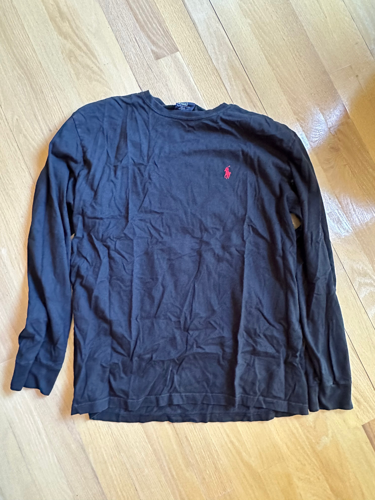

Score: 0.54 | CAPTION: A pair of black pants made of cotton. They have a straight leg and a relaxed fit.


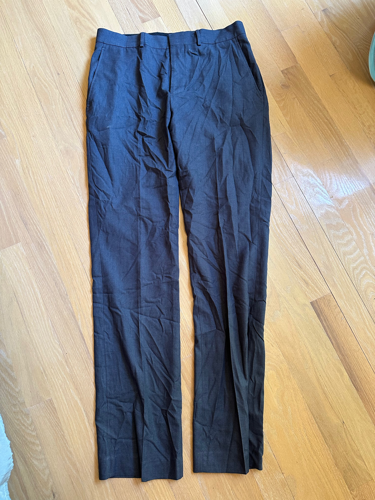

Score: 0.33 | CAPTION: A pair of black pants made of cotton. They have a relaxed fit and a zip fly closure.


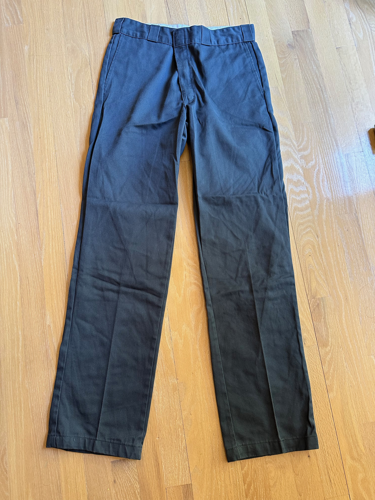

Score: 0.42 | CAPTION: A blue jacket with a collar and long sleeves. It is made of a thick material and is suitable for winter wear.


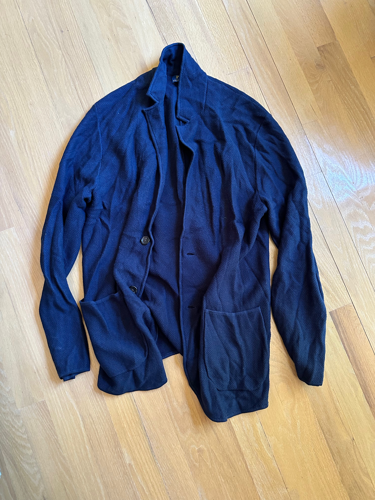

In [66]:
for c in resp:
    result = picker.gt_clothing(str(c))
    print(f"Score: {result[1]:.2f} | CAPTION: {result[0].description}")
    display(result[0].image)

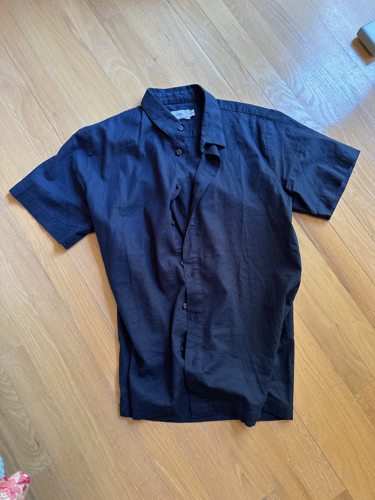

In [23]:
picker.gt_clothing(c1['clothing description'])[0][0].image

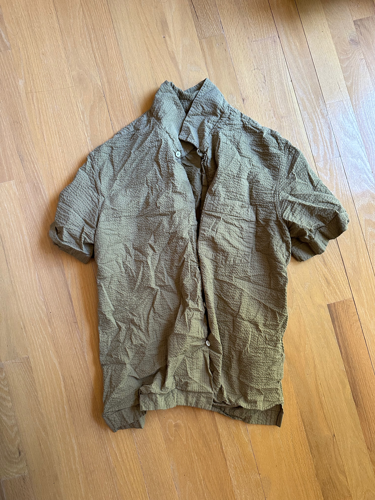

In [22]:
picker.gt_clothing(str(c1))[0][0].image

# TODO:

- recreate db table with all of my clothes content
- Make clothes-planning function work end-to-end
- Refactor files to make readable
- Dockerize and make a flask (or fastapi) server so I can serve it as an endpoint

## BIG CHANGE:
- Figure out how to do userid provisioning on the backend so I can store "user" data
- Update DB schema to have my clothes all there (perhaps with hand annotations?)
- render website to plan outfits for Zubin's Closet **BIG WORK REQUIRED**

# PLAYGROUND

In [127]:
vector_db.unit_vectors=True
a = vector_db.embed(all_clothes[30])
print(torch.dot(a,a))

tensor(1.0000)


In [46]:
arr = np.random.randint(0,10,(100,30))

In [48]:
arr.shape

(100, 30)

In [55]:
i=99
np.vstack((arr[:i,], arr[i+1:,])).shape

(99, 30)

In [61]:
i=10
(np.delete(arr, i,0) == np.vstack((arr[:i,], arr[i+1:,]))).mean()

1.0

In [80]:
# lets check speed
size=(100000,1000)
deleted = np.random.randint(0,100, size)
indexed = np.array(deleted, copy=True)
i = [np.random.randint(0,size[0]-ii) for ii in range(100)]

In [81]:
# DELETED TIME
s = time.time()
for v in i:
    deleted = np.delete(deleted, v, 0)
print(f"Deletion Time: {time.time() - s} seconds")

Deletion Time: 10.835004806518555 seconds


In [82]:
# Indexed TIME
s = time.time()
for v in i:
    indexed = np.vstack((indexed[:v,], indexed[v+1:,]))
print(f"Indexed Time: {time.time() - s} seconds")

Indexed Time: 12.774151086807251 seconds


In [83]:
del deleted
del indexed
del i